In [1]:
## Import common python libraries
import sys
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Import from root_numpy library
import root_numpy
from root_numpy import root2array, rec2array

# Import panda library
from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix
from pandas.core.index import Index
import pandas.core.common as com

# Import scipy
import scipy
from scipy.stats import ks_2samp
import scipy as sp

# Import itertools
import itertools
from itertools import cycle

# Import Jupyter
from IPython.core.interactiveshell import InteractiveShell

# Import scikit-learn
import sklearn
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RandomizedLasso

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.feature_selection import RFECV
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import (confusion_matrix, roc_auc_score, roc_curve, 
                             auc, average_precision_score, precision_score, 
                             brier_score_loss, recall_score, f1_score, log_loss, 
                             classification_report, precision_recall_curve)
from sklearn.dummy import DummyClassifier

from sklearn.externals import joblib
from sklearn import feature_selection

# Import imblearn
import imblearn
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from collections import defaultdict, Counter

# python regular-expression
import re

# Sciki-kit learn graph 
from sklearn.tree import export_graphviz

# Check the versions of libraries/packages
print("Python version " + sys.version)
print("Sklearn version " + sklearn.__version__)
print("Root_numpy version " + root_numpy.__version__)
print("Numpy version " + np.__version__)
print("Scipy version " + scipy.__version__)
print("Pandas version " + pd.__version__)
print("Matplotlib version " + matplotlib.__version__)
print("Seaborn version " + sns.__version__)
print("Imblance version " +imblearn.__version__)

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Specifying which nodes should be run interactively
InteractiveShell.ast_node_interactivity = "all"
print(__doc__)

Welcome to ROOTaaS 6.06/08
Python version 2.7.13 (v2.7.13:a06454b1afa1, Dec 17 2016, 12:39:47) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]
Sklearn version 0.18.1
Root_numpy version 4.7.2
Numpy version 1.12.0
Scipy version 0.18.1
Pandas version 0.19.0+515.gd0a281f
Matplotlib version 2.0.0
Seaborn version 0.8.dev
Imblance version 0.2.1
Automatically created module for IPython interactive environment


## Load data files

In [2]:
## Data loading function

def load(sig_filename, bkg_filename, category, features):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    Parameters
    ----------
    sig_filename : array, shape = [n_samples]
            true class, intergers in [0, n_classes - 1)
    bkg_filename : array, shape = [n_samples, n_classes]
    category: string
    features: array, shape = [n_features]

    Returns
    -------
    data : pandas.DataFrame
    """

    signal = root2array(sig_filename, category, features)
    signal = rec2array(signal)

    backgr = root2array(bkg_filename, category, features)
    backgr = rec2array(backgr)

    # for sklearn data is usually organised
    # into one 2D array of shape (n_samples x n_features)
    # containing all the data and one array of categories
    # of length n_samples
    X = np.concatenate((signal, backgr))
    y = np.concatenate((np.ones(signal.shape[0]), np.zeros(backgr.shape[0])))

    # convert to numpy ndarray into pandas dataframe
    dataframe_X = pd.DataFrame(data=X, columns=features)
    dataframe_y = pd.DataFrame(data=y, columns=['y'])

    data = pd.concat([dataframe_X, dataframe_y], axis=1)

    return data

In [3]:
## Load input data files

# Feature names
branch_names = """mass_tag_tag_min_deltaR,median_mass_jet_jet,
    maxDeltaEta_tag_tag,mass_higgsLikeDijet,HT_tags,
    btagDiscriminatorAverage_tagged,mass_jet_tag_min_deltaR,
    mass_jet_jet_min_deltaR,mass_tag_tag_max_mass,maxDeltaEta_jet_jet,
    centrality_jets_leps,centrality_tags,globalTimesEventWeight""".split(",")

features = [c.strip() for c in branch_names]
features = (b.replace(" ", "_") for b in features)
features = list(b.replace("-", "_") for b in features)

wall = time.time()
process = time.clock()

# Load dataset
signal_sample = "combined/signalMC.root"
background_sample = "combined/backgroundMC.root"
tree_category = "event_mvaVariables_step7_cate4"

data = load(signal_sample, background_sample, tree_category, features)

print "Total number of events: {}\nNumber of features: {}".format(data.shape[0], data.shape[1])

# Store a copy for later use
df_archived = data.copy(deep=True)

print "\nWall time to read in file input: ", time.time()-wall
print "Elapsed time to read in file input: ", time.clock()-process

Total number of events: 11502
Number of features: 14

Wall time to read in file input:  0.145325183868
Elapsed time to read in file input:  0.140121


In [4]:
## Function to extract class label counts and percentage

def class_info(classes):
    # Store the number of signal and background events
    class_count = {}
    counts = Counter(classes)
    total = sum(counts.values())

    for cls in counts.keys():
        class_count[class_label[cls]] = counts[cls]
        print("%10s: %7d  =  % 5.1f%%" % (class_label[cls], counts[cls], float(counts[cls])/float((total))*100.0))

    return (class_count["signal"], class_count["background"])

In [5]:
## Determine class label counts and percentages

class_label = {0.0: "background", 1.0: "signal"}
class_info(data.y);

background:    6777  =   58.9%
    signal:    4725  =   41.1%


In [6]:
## Create features dataframe and target array

df_X = data.drop("y", axis=1, inplace=False)
df_y = data["y"]

## Statistical summary

In [7]:
## Print statistical summary of dataset

# To print out all rows and columns to the terminal
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

wall = time.time()
process = time.clock()

print "Head:"
data.head()

print "Describe:"
data.describe()

print "Describe based on signal or data:"
data.groupby('y').describe()

print "Information:" 
data.info()


print "\nWall time to print statistical summary: ", time.time()-wall
print "Elapsed time to print statistical summary: ", time.clock()-process

Head:


,mass_tag_tag_min_deltaR,median_mass_jet_jet,maxDeltaEta_tag_tag,mass_higgsLikeDijet,HT_tags,btagDiscriminatorAverage_tagged,mass_jet_tag_min_deltaR,mass_jet_jet_min_deltaR,mass_tag_tag_max_mass,maxDeltaEta_jet_jet,centrality_jets_leps,centrality_tags,globalTimesEventWeight,y
0,147.846252,132.468857,0.687603,121.850945,541.808899,0.930030,70.543983,70.543983,346.367706,3.860818,0.428497,0.497305,2.063273,1.0
1,108.483505,77.382843,0.864248,135.828598,337.069611,0.950204,41.899509,41.899509,108.483505,3.070951,0.622126,0.816453,2.348438,1.0
2,105.684814,105.684814,1.058237,119.816292,315.525421,0.982161,105.684814,105.684814,179.085861,3.676557,0.558623,0.811920,1.711291,1.0
3,95.740837,159.740494,1.064351,123.214333,793.738770,0.947199,95.740837,95.740837,394.918854,1.817336,0.772420,0.925377,2.811765,1.0
4,46.943771,102.658394,0.745558,109.506470,341.026093,0.937956,46.943771,46.943771,199.907959,1.285695,0.900433,0.971768,2.624357,1.0


Describe:


,mass_tag_tag_min_deltaR,median_mass_jet_jet,maxDeltaEta_tag_tag,mass_higgsLikeDijet,HT_tags,btagDiscriminatorAverage_tagged,mass_jet_tag_min_deltaR,mass_jet_jet_min_deltaR,mass_tag_tag_max_mass,maxDeltaEta_jet_jet,centrality_jets_leps,centrality_tags,globalTimesEventWeight,y
count,11502.000000,11502.000000,11502.000000,11502.000000,11502.000000,11502.000000,11502.000000,11502.000000,11502.000000,11502.000000,11502.000000,11502.000000,11502.000000,11502.000000
mean,72.794937,130.884079,1.999546,123.582291,330.700500,0.953733,59.162647,57.746330,277.902466,2.555769,0.611077,0.644550,20.714117,0.410798
std,44.363853,53.103275,0.853363,12.654324,148.160446,0.022884,34.898560,34.171822,166.944412,0.935243,0.140324,0.165861,18.068237,0.492000
min,12.633512,34.977924,0.056909,31.166857,106.436119,0.862530,12.552081,12.552081,44.503445,0.056909,0.238576,0.220871,-4.501039,0.000000
25%,41.649353,95.079142,1.353945,118.288080,230.768669,0.938434,34.224159,33.378013,167.251320,1.849569,0.505054,0.516360,2.407704,0.000000
50%,61.460218,119.805786,1.916782,124.319786,296.221405,0.955591,49.430418,48.307941,233.957787,2.543590,0.608996,0.652510,26.219136,0.000000
75%,94.571838,153.676071,2.571373,129.130924,388.999527,0.970816,73.925880,72.215767,336.919250,3.238992,0.715097,0.776901,35.608419,1.000000
max,940.192627,599.893066,4.743262,282.346588,2481.391113,0.998742,348.198029,348.198029,2664.628906,4.773415,0.966779,0.989593,129.178177,1.000000


Describe based on signal or data:


HT_tags                                                              \
      count        mean         std         min         25%         50%   
y                                                                         
0.0  6777.0  321.487762  150.685211  106.436119  219.696579  286.809235   
1.0  4725.0  343.914246  143.448624  115.094009  247.114120  312.044312   

                             btagDiscriminatorAverage_tagged            \
            75%          max                           count      mean   
y                                                                        
0.0  378.288879  2014.397339                          6777.0  0.950799   
1.0  401.951355  2481.391113                          4725.0  0.957941   

                                                                 \
          std       min       25%       50%       75%       max   
y                                                                 
0.0  0.023452  0.862530  0.934758  0.952232  0.967950  0.998556   
1.0  0.021353  0.876634  0.943906  0.959807  0.973915  0.998742   

    centrality_jets_leps                                                    \
                   count      mean       std       min       25%       50%   
y                                                                            
0.0               6777.0  0.587761  0.136666  0.238576  0.482854  0.580350   
1.0               4725.0  0.644520  0.138742  0.250759  0.546510  0.647717   

                        centrality_tags                                \
          75%       max           count      mean       std       min   
y                                                                       
0.0  0.685269  0.959634          6777.0  0.615476  0.165629  0.220871   
1.0  0.749177  0.966779          4725.0  0.686251  0.157080  0.243452   

                                            globalTimesEventWeight             \
          25%       50%       75%       max                  count       mean   
y                                                                               
0.0  0.484467  0.614423  0.746403  0.983625                 6777.0  33.613289   
1.0  0.572414  0.698631  0.812155  0.989593                 4725.0   2.213017   

                                                                       \
           std       min        25%        50%        75%         max   
y                                                                       
0.0  12.188628  0.000000  29.738295  34.277512  39.356163  129.178177   
1.0   0.800871 -4.501039   2.074176   2.345649   2.597323    5.342217   

    mass_higgsLikeDijet                                                \
                  count        mean        std        min         25%   
y                                                                       
0.0              6777.0  123.744392  14.309190  31.166857  117.743820   
1.0              4725.0  123.349785   9.801565  75.559570  118.936356   

                                        mass_jet_jet_min_deltaR             \
            50%         75%         max                   count       mean   
y                                                                            
0.0  124.341484  129.836182  282.346588                  6777.0  54.599808   
1.0  124.275742  128.401291  189.629761                  4725.0  62.259354   

                                                                        \
           std        min        25%        50%        75%         max   
y                                                                        
0.0  34.074547  12.552081  31.502815  45.141697  66.556816  348.198029   
1.0  33.806927  13.061691  36.973450  52.908707  80.151176  306.003296   

    mass_jet_tag_min_deltaR                                              \
                      count       mean        std        min        25%   
y                                                                         
0.0                  6777.0  55.922966 

Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11502 entries, 0 to 11501
Data columns (total 14 columns):
mass_tag_tag_min_deltaR            11502 non-null float32
median_mass_jet_jet                11502 non-null float32
maxDeltaEta_tag_tag                11502 non-null float32
mass_higgsLikeDijet                11502 non-null float32
HT_tags                            11502 non-null float32
btagDiscriminatorAverage_tagged    11502 non-null float32
mass_jet_tag_min_deltaR            11502 non-null float32
mass_jet_jet_min_deltaR            11502 non-null float32
mass_tag_tag_max_mass              11502 non-null float32
maxDeltaEta_jet_jet                11502 non-null float32
centrality_jets_leps               11502 non-null float32
centrality_tags                    11502 non-null float32
globalTimesEventWeight             11502 non-null float32
y                                  11502 non-null float64
dtypes: float32(13), float64(1)
memory usage: 674.0 KB

Wall time 

## Feature visualization: basic exploratory data analysis

In [8]:
# Plot AUC for ROC curve for several classifiers out-of-the-box

# Set feature scaling type
scaler = RobustScaler()

# prepare models: create a mapping of ML classifier name to algorithm
pipe_classifiers = {
    'SVC':  make_pipeline(scaler, SVC(class_weight="balanced")), # sample_weight included
    'LogisticRegression'    : make_pipeline(scaler, LogisticRegression(class_weight="balanced")),
    'AdaBoostClassifier'    : make_pipeline(None,   AdaBoostClassifier()),
    'RandomForestClassifier': make_pipeline(None,   RandomForestClassifier(min_samples_leaf=10)),
    'DecisionTreeClassifier': make_pipeline(None,   DecisionTreeClassifier(min_samples_leaf=10,
                                                                           class_weight="balanced")),
    'GradientBoostingClassifier': make_pipeline(None,   GradientBoostingClassifier(min_samples_leaf=10)),
    'BaggingClassifier': make_pipeline(None,   BaggingClassifier(n_estimators=1000)),
    'ExtraTreesClassifier' :  make_pipeline(None, ExtraTreesClassifier(min_samples_leaf=10)),#,
    
    #'LinearDiscriminantAnalysis':  make_pipeline(scaler, LinearDiscriminantAnalysis()),
    #'KNeighborsClassifier':  make_pipeline(scaler, KNeighborsClassifier()),
    #'GaussianNB' :  make_pipeline(scaler, GaussianNB()), 
    #'MLPClassifier':  make_pipeline(scaler, MLPClassifier()), 
}

In [9]:
## Plot signal and background distributions for some variables

def signal_background(data1, data2, column=None, grid=True,
                      xlabelsize=None, xrot=None, ylabelsize=None,
                      yrot=None, ax=None, sharex=False,
                      sharey=False, figsize=None,
                      layout=None, bins=10, **kwds):
    """Draw histogram of the DataFrame's series comparing the distribution
    in `data1` to `data2`.

    data1: DataFrame
    data2: DataFrame
    column: string or sequence
       If passed, will be used to limit data to a subset of columns
    grid : boolean, default True
       Whether to show axis grid lines
    xlabelsize : int, default None
       If specified changes the x-axis label size
    xrot : float, default None
       rotation of x axis labels
    ylabelsize : int, default None
       If specified changes the y-axis label size
    yrot : float, default None
       rotation of y axis labels
    ax : matplotlib axes object, default None
    sharex : bool, if True, the X axis will be shared amongst all subplots.
    sharey : bool, if True, the Y axis will be shared amongst all subplots.
    figsize : tuple
       The size of the figure to create in inches by default
    layout: (optional) a tuple (rows, columns) for the layout of the histograms
    bins: integer, default 10
       Number of histogram bins to be used
    kwds : other plotting keyword arguments
       To be passed to hist function
    """
    manification=20
    background_weight = data1["globalTimesEventWeight"]
    signal_weight = data2["globalTimesEventWeight"]*manification

    if "alpha" not in kwds:
        kwds["alpha"] = 0.5

    w, h = (12, 8)
    figsize = (w, h)

    if column is not None:
        if not isinstance(column, (list, np.ndarray, Index)):
            column = [column]
        data1 = data1[column]
        data2 = data2[column]

    data1 = data1._get_numeric_data()
    data2 = data2._get_numeric_data()
    naxes = len(data1.columns)


    fig, axes = plotting._subplots(naxes=naxes,
                                   ax=ax, 
                                   squeeze=False,
                                   sharex=sharex,
                                   sharey=sharey,
                                   figsize=figsize,
                                   layout=layout)
    xs = plotting._flatten(axes)

    for i, col in enumerate(com._try_sort(data1.columns)):
        ax = xs[i]
        low = min(data1[col].min(), data2[col].min())
        high = max(data1[col].max(), data2[col].max())
        ax.hist(data1[col].dropna().values, weights=background_weight, 
               bins=bins, histtype='stepfilled', range=(low,high), **kwds)
        ax.hist(data2[col].dropna().values, weights=signal_weight,
                   bins=bins, histtype='stepfilled', range=(low,high), **kwds)
        ax.set_title(col)
        ax.legend(['background', 'signal (%s)'% (manification)], loc='best')
        ax.set_facecolor('white')
    
        # Customize the major grid
        ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
        ax.set_facecolor('white')
    

    plotting._set_ticks_props(axes, xlabelsize=xlabelsize, xrot=xrot,
                             ylabelsize=ylabelsize, yrot=yrot)
    fig.subplots_adjust(wspace=0.5, hspace=0.8)

    return plt.show()

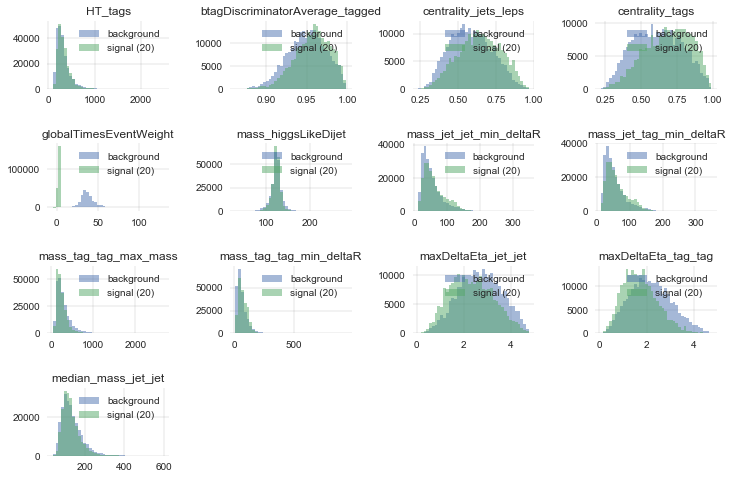


Wall time to plot exploratory data features:  2.07348299026
Elapsed time to plot exploratory data features:  1.916028


In [10]:
## Plot feature distributions

wall = time.time()
process = time.clock()

signal_background(data[data["y"] < 0.5],
                  data[data["y"] > 0.5],
                  column=features, bins=40);

print "\nWall time to plot exploratory data features: ", time.time()-wall
print "Elapsed time to plot exploratory data features: ", time.clock()-process

In [11]:
## Linear correlation matrix

def correlations(data, **kwds):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    Parameters
    ----------
    data : array, shape = [n_samples]
            true class, intergers in [0, n_classes - 1)
    kwds : array, shape = [n_samples, n_classes]

    Returns
    -------
    loss : float
    """
        
    
    """To calculate pairwise correlation between features.
    
    Extra arguments are passed on to DataFrame.corr()
    """
    
    # Select signal or background label for plot title
    if (data["y"] > 0.5).all(axis=0):
        label = "signal"
    elif (data["y"] < 0.5).all(axis=0):
        label = "background"
    
    # simply call df.corr() to get a table of
    # correlation values if you do not need
    # the fancy plotting
    data = data.drop("y", axis=1) 
 
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    labels = data.corr(**kwds).columns.values
    
    fig, ax1 = plt.subplots(ncols=1, figsize=(9,8))
    
    opts = {"annot" : True,
            "ax" : ax1,
            "vmin": 0, "vmax": 1*100,
            "annot_kws" : {"size": 8}, 
            "cmap": plt.get_cmap("Blues", 20),
            }
    
    ax1.set_title("Correlations: " + label)

    sns.heatmap(data.corr(method="spearman").iloc[::-1]*100, **opts) 
    
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    
    for ax in (ax1,):
        # shift location of ticks to center of the bins
        ax.set_xticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_yticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_xticklabels(labels[::-1], minor=False, ha="right", rotation=70)
        ax.set_yticklabels(np.flipud(labels), minor=False)
        
    plt.tight_layout()
    
    return plt.show()

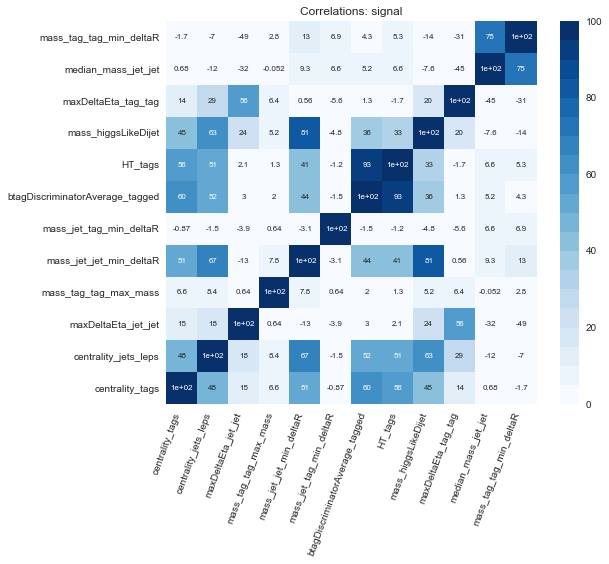

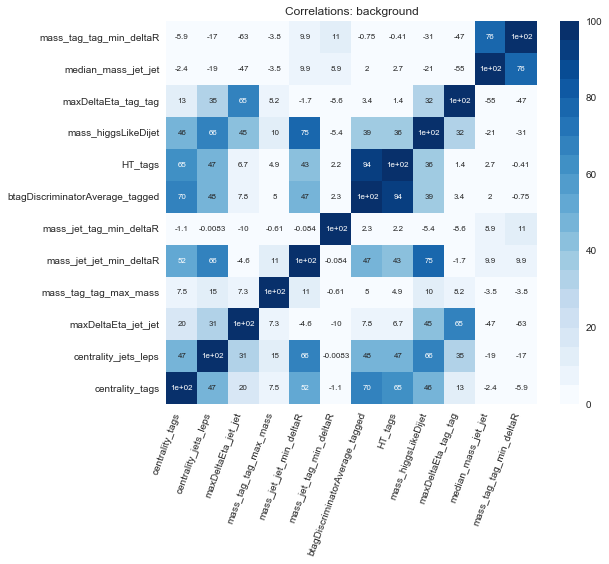

Wall time to plot correlation matrix:  2.02183008194
Elapsed time to plot correlation matrix:  2.006769


In [12]:
## Plot feature correlations (assumes linear correlations)

wall = time.time()
process = time.clock()

# Remove the y column from the correlation matrix
# after using it to select background and signal
sig = data[data["y"] > 0.5].drop('globalTimesEventWeight', axis=1, inplace=False)
bg = data[data["y"] < 0.5].drop('globalTimesEventWeight', axis=1, inplace=False)

# Correlation Matrix
correlations(sig)
correlations(bg)

print "Wall time to plot correlation matrix: ", time.time()-wall
print "Elapsed time to plot correlation matrix: ", time.clock()-process

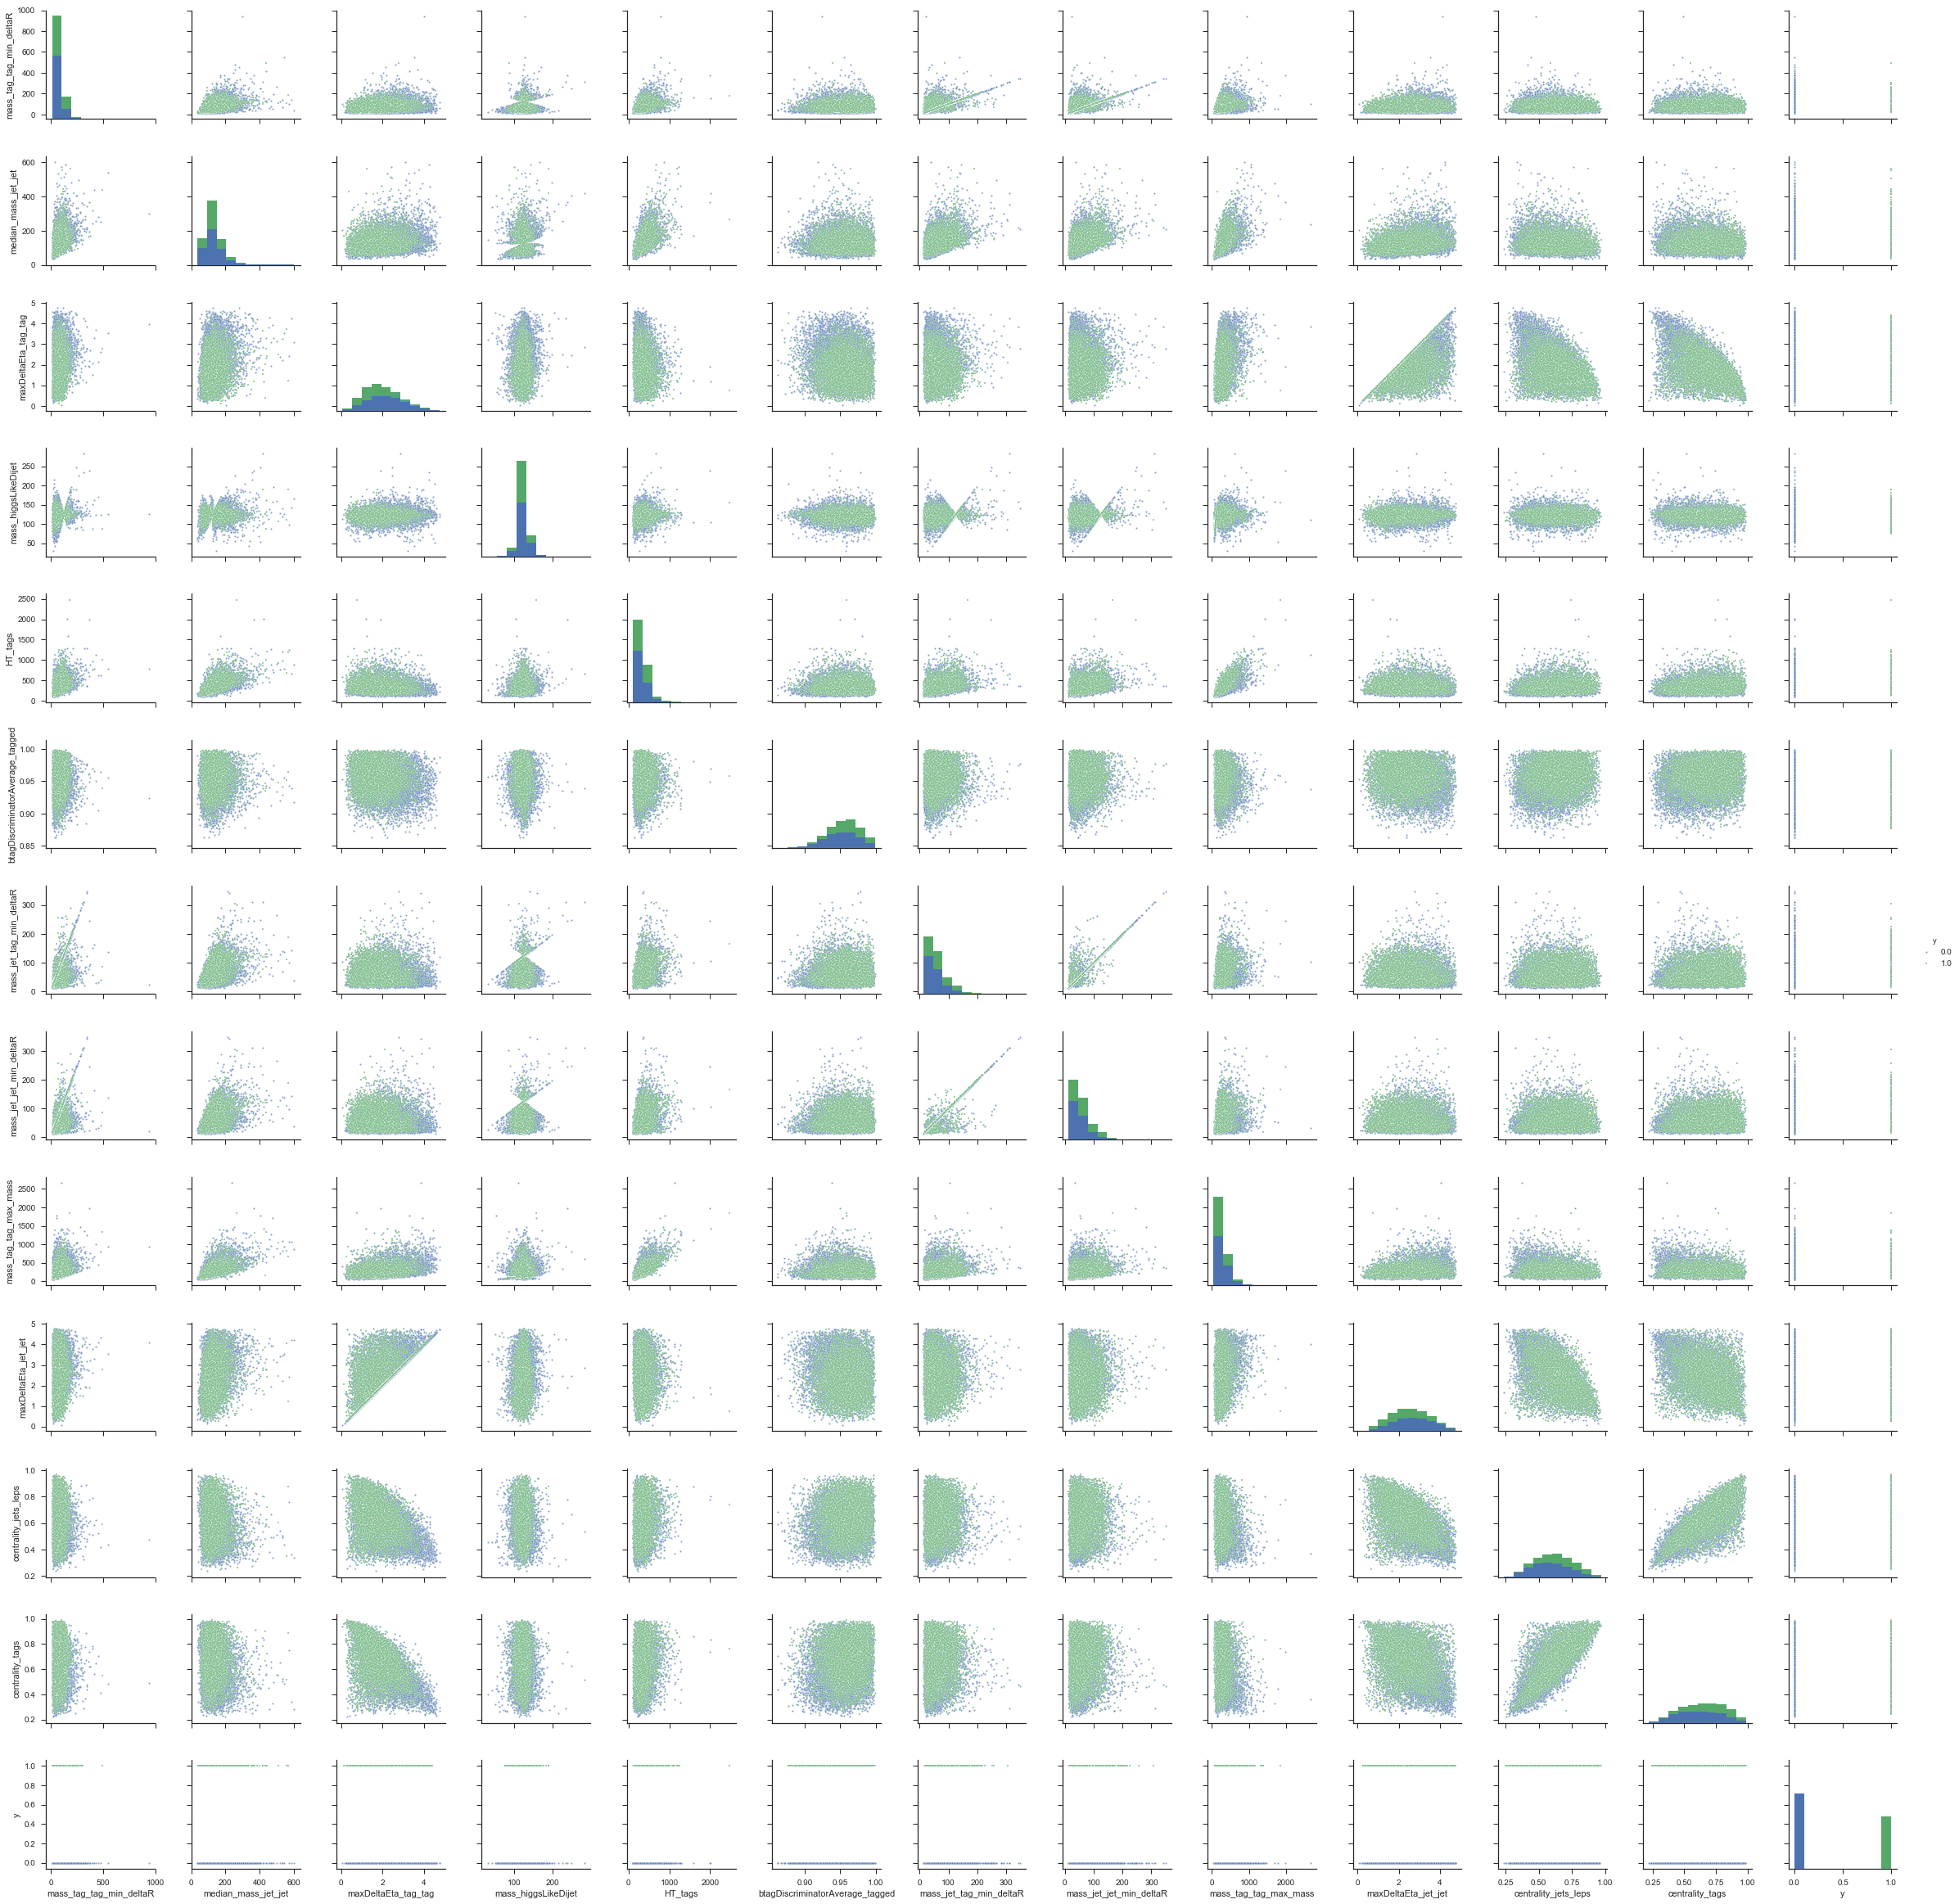

Wall time to plot scatter distribution:  50.0661129951
Elapsed time to plot scatter distribution:  47.491893


In [13]:
## Scatter Plot
#%matplotlib inline

wall = time.time()
process = time.clock()

sns.set(style="ticks", color_codes=True)

random.seed(a=seed)

_ = sns.pairplot(data.drop(["globalTimesEventWeight"], axis=1), size=2.5, hue="y", 
                 markers=["o", "s"], plot_kws={ "s":5,"alpha":0.7 })
plt.show()

print "Wall time to plot scatter distribution: ", time.time()-wall
print "Elapsed time to plot scatter distribution: ", time.clock()-process

## Model performance measure

In [14]:
## Compute ROC curve and area under the curve

def roc_plot(models, X, y, n_folds=3, sample_weight_flag=True):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    Parameters
    ----------
    models : dictionary, shape = [n_models]
    X : DataFrame, shape = [n_samples, n_classes]
    y : DataFrame, shape = [n_classes]

    Returns
    -------
    roc : matplotlib plot
    """

    # Split data into a development and evaluation set
    X_dev, X_eval, y_dev, y_eval = train_test_split(X, y, test_size=0.33, random_state=42)

    # Split development set into a train and test set
    X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, 
                                                        test_size=0.33, random_state=seed)

    # Extract training and test weights from dataset
    sample_weight_dev = X_dev["globalTimesEventWeight"].values
    sample_weight_train = X_train["globalTimesEventWeight"].values
    sample_weight_test = X_test["globalTimesEventWeight"].values

    X_train = X_train.drop('globalTimesEventWeight', axis=1, inplace=False)
    X_test = X_test.drop('globalTimesEventWeight', axis=1, inplace=False)

    # contains rates for ML classifiers
    fpr = {}
    tpr = {}
    roc_auc = {}

    # Customize the major grid
    fig, ax = plt.subplots()
    ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax.set_facecolor('white')

    # Include random by chance 'luck' curve
    plt.plot([1, 0], [0, 1], '--', color=(0.1, 0.1, 0.1), label='Luck')

    # Loop through classifiers
    for (name, model) in models.items():

        print "\n\x1b[1;31mBuilding model ...\x1b[0m"
        process = time.clock()
        if sample_weight_flag:
            model.fit(X_train, y_train, **{name.lower()+'__sample_weight': sample_weight_train})
        else:
            model.fit(X_train, y_train)

        print "\t%s fit time: %.3f"%(name, time.clock()-process)

        y_predicted = model.predict(X_test)

        process = time.clock()

        # Statistics summary report
        print classification_report(y_test, y_predicted, 
                                    target_names=['signal', 'background'],
                                    sample_weight=sample_weight_test)
        print("\tScore (i.e. accuracy) of test dataset: {:.5f}"
              .format(model.score(X_test, y_test, #sample_weight=sample_weight_test
                                 )))

        scores = cross_val_score(model, 
                                 X_dev.drop('globalTimesEventWeight', axis=1, inplace=False), y_dev,
                                 scoring="roc_auc", cv=n_folds, n_jobs=-1,
                                 fit_params={name.lower()+'__sample_weight': sample_weight_dev})

        print "\tCross-validated AUC ROC score: %0.5f (+/- %0.5f)"%(scores.mean(), scores.std())

        if hasattr(model, "predict_proba"):
            # probability estimates of the positive class(as needed in the roc_curve function)
            decisions = model.predict_proba(X_test)[:, 1]
        else:  # use decision function
            decisions = model.decision_function(X_test)

        process = time.clock()
        fpr[name], tpr[name], thresholds = roc_curve(y_test, decisions, sample_weight=sample_weight_test)

        # Non-cross-validated AUROC
        roc_auc[name] = auc(fpr[name], tpr[name])
        print "\tAUC ROC score for %s: %.4f"%(name, roc_auc[name])
        print "\tAUC ROC time: ", time.clock()-process

    # color choices: https://css-tricks.com/snippets/css/named-colors-and-hex-equivalents/
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 
                    'green', 'yellow', 'SlateBlue', 'DarkSlateGrey',
                    'CadetBlue', 'Chocolate', 'darkred', 'GoldenRod'])

    for (name, model), color in zip(models.items(), colors):

        signal_efficiecy = tpr[name] # true positive rate (tpr)
        background_efficiecy = fpr[name] # false positive rate (fpr)
        # NOTE: background rejection rate = 1 - background efficiency (i.e specicity)
        background_rejection_rate = 1 - background_efficiecy

        plt.plot(signal_efficiecy, background_rejection_rate, color=color, lw=2,
                 label='%s (AUC = %0.3f)'%(name, roc_auc[name]))                 

    # Plot all ROC curves
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Signal Efficiency (True Positive Rate)')
    plt.ylabel('Background Rejection Rate (1- False Positive Rate)')
    plt.title("Receiver operating characteristic ({} events)".format(X.shape[0]))
    leg = plt.legend(loc="lower left", frameon=True, fancybox=True, fontsize=10) # loc='best'
    leg.get_frame().set_edgecolor('w')
    frame = leg.get_frame()
    frame.set_facecolor('White')

    return plt.show() 


Building model ...
	LogisticRegression fit time: 0.026
             precision    recall  f1-score   support

     signal       0.96      1.00      0.98 50608.7316911
 background       0.00      0.00      0.00 2288.02928561

avg / total       0.92      0.96      0.94 52896.7609767

	Score (i.e. accuracy) of test dataset: 0.59497


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


	Cross-validated AUC ROC score: 0.69806 (+/- 0.00746)
	AUC ROC score for LogisticRegression: 0.7102
	AUC ROC time:  0.003918

Building model ...
	BaggingClassifier fit time: 84.940
             precision    recall  f1-score   support

     signal       0.97      0.72      0.83 50608.7316911
 background       0.08      0.54      0.14 2288.02928561

avg / total       0.93      0.71      0.80 52896.7609767

	Score (i.e. accuracy) of test dataset: 0.64491
	Cross-validated AUC ROC score: 0.68796 (+/- 0.01190)
	AUC ROC score for BaggingClassifier: 0.6890
	AUC ROC time:  0.00406699999999

Building model ...
	ExtraTreesClassifier fit time: 0.053
             precision    recall  f1-score   support

     signal       0.96      1.00      0.98 50608.7316911
 background       0.00      0.00      0.00 2288.02928561

avg / total       0.92      0.96      0.94 52896.7609767

	Score (i.e. accuracy) of test dataset: 0.59497
	Cross-validated AUC ROC score: 0.71345 (+/- 0.00834)
	AUC ROC score for ExtraT

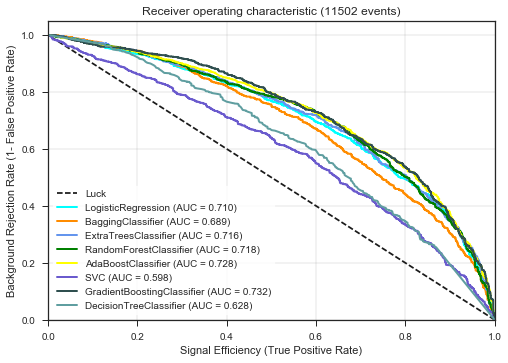


Wall time to generate ROC plots:  240.911516905
Elapsed time to generate ROC plots:  96.952215


In [15]:
## Assessing the various classifiers performance

wall = time.time()
process = time.clock()

roc_plot(pipe_classifiers, df_X, df_y)

print "\nWall time to generate ROC plots: ", time.time()-wall
print "Elapsed time to generate ROC plots: ", time.clock()-process

In [16]:
## Define precision-recall curve

def plot_PR_curve(classifier, X, y, n_folds=5):
    """
    Plot a basic precision/recall curve.
    """

    # Convert negative weights to 1.0 (or else average_precision_score crashes)
    X["globalTimesEventWeight"] = X["globalTimesEventWeight"].map(lambda x: 1.0 if x < 0.0 else x)
    signal_sample_weight = X["globalTimesEventWeight"][y>0.5].values
    background_sample_weight = X["globalTimesEventWeight"][y<0.5].values

    # Customize the major grid
    fig, ax = plt.subplots()
    ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax.set_facecolor('white')

    # Calculate the random luck for PR 
    # (above the constant line is a classifier that is well modeled)
    signal_count = sum(signal_sample_weight*y[y>0.5])
    background_count = sum(background_sample_weight*np.ones(len(y[y<0.5])))
    ratio = float(signal_count)/float(signal_count + background_count)

    # store average precision calculation
    avg_scores = []

    # Loop through classifiers
    for (name, model) in classifier.items():

        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

        for train, test in skf.split(X, y):

            # Transform numpy array into panda dataframe to easier drop features
            training_samples = pd.DataFrame(X.iloc[train], columns=features)
            test_samples = pd.DataFrame(X.iloc[test], columns=features)

            # Extract training and test sample weights from the dataset
            sample_weight_train = training_samples["globalTimesEventWeight"].values
            sample_weight_test = test_samples["globalTimesEventWeight"].values

            # Drop event/sample weight feature
            training_samples = training_samples.drop('globalTimesEventWeight',
                                                     axis=1, inplace=False)
            test_samples = test_samples.drop('globalTimesEventWeight',
                                             axis=1, inplace=False)

            model.fit(training_samples, y[train],
                      **{name.lower()+'__sample_weight': sample_weight_train})   

            if hasattr(model, "predict_proba"):
                probas_ = model.predict_proba(test_samples)[:, 1]
            else:  # use decision function
                probas_ = model.decision_function(test_samples)

            # Compute precision recall curve
            precision, recall, thresholds = precision_recall_curve(y[test], probas_, pos_label=1,
                                                                  sample_weight=sample_weight_test)
            # Area under the precision-recall curve (AUCPR)
            sample_weight_test = np.ones(len(sample_weight_test))

            average_precision = average_precision_score(y[test], probas_, sample_weight=sample_weight_test)
            avg_scores.append(average_precision)

        plt.plot(recall, precision, lw=1, 
                 label='{0} (auc = {1:0.2f})'.format(name,np.mean(avg_scores, axis=0)))

    plt.plot([ratio,ratio], '--', color=(0.1, 0.1, 0.1), 
             label='Luck (auc = {0:0.2f})'.format(ratio))

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-recall curve')
    plt.legend(loc="upper right")

    return plt.show()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/metrics/ranking.py:414: RuntimeWarning: invalid value encountered in true_divide
  precision = tps / (tps + fps)


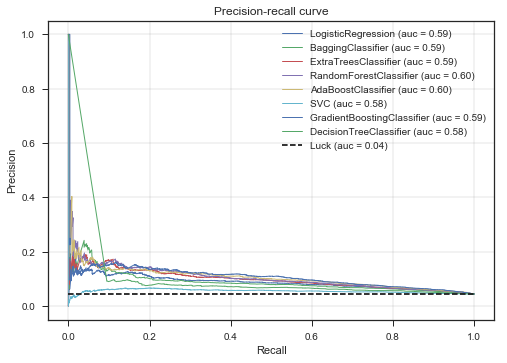


Wall time to generate Precision-Recall plots:  535.460633993
Elapsed time to generate Precision-Recall plots:  475.484979


In [17]:
# Plot precision-recall curve for several classifiers out-of-the-box

wall = time.time()
process = time.clock()

plot_PR_curve(pipe_classifiers, df_X, df_y, n_folds=3)

print "\nWall time to generate Precision-Recall plots: ", time.time()-wall
print "Elapsed time to generate Precision-Recall plots: ", time.clock()-process

## Overfitting evaluation

In [ ]:
## Overfitting check

def compare_train_test(clf, X_in, y_in, bins=30):
    """Multi class version of Logarithmic Loss metric.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
            true class, intergers in [0, n_classes - 1)
    y_pred : array, shape = [n_samples, n_classes]

    Returns
    -------
    loss : float
    """
    
    if hasattr(clf, "steps"):
        name = clf.steps[1][1].__class__.__name__
    else:
        name = clf.__class__.__name__
    
    # Split data into a development and evaluation set
    #X_dev,X_eval, y_dev,y_eval = train_test_split(X_in, y_in, 
    #                                              test_size=0.33, random_state=42)
    # Split development set into a train and test set
    #X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, 
    #                                                    test_size=0.33, random_state=seed)
    
    # Split development set into a train and test set
    X_train, X_test, y_train, y_test = train_test_split(X_in, y_in, 
                                                        test_size=0.50, random_state=seed)
   
    sample_weight_train = X_train["globalTimesEventWeight"].values
    
    # Extract signal and background weights for traning set
    signal_sample_weight_train = X_train["globalTimesEventWeight"][y_train>0.5].values
    background_sample_weight_train = X_train["globalTimesEventWeight"][y_train<0.5].values
    
    signal_sample_weight_test = X_test["globalTimesEventWeight"][y_test>0.5].values
    background_sample_weight_test = X_test["globalTimesEventWeight"][y_test<0.5].values
    
    X_train = X_train.drop('globalTimesEventWeight', axis=1, inplace=False)
    X_test = X_test.drop('globalTimesEventWeight', axis=1, inplace=False)

    # use subplot to extract axis to add ks and p-value to plot
    fig, ax = plt.subplots()
    
    # Customize the major grid
    ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax.set_facecolor('white')
    
    if name != "CalibratedClassifierCV":
        clf.fit(X_train,y_train, **{name.lower()+'__sample_weight': sample_weight_train})
    else:
        clf.fit(X_train,y_train, **{'sample_weight': sample_weight_train})
    
    decisions = []    
    for X, y in ((X_train, y_train), (X_test, y_test)):

        if hasattr(clf,"decision_function"):
            d1 = clf.decision_function(X[y>0.5]).ravel()
            d2 = clf.decision_function(X[y<0.5]).ravel()
        else:
            d1 = clf.predict_proba(X[y>0.5])[:, 1]
            d2 = clf.predict_proba(X[y<0.5])[:, 1]
        
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)

    # training signal and background histograms
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True, weights=signal_sample_weight_train,
             label='signal (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins, 
             histtype='stepfilled', normed=True, weights=background_sample_weight_train,
             label='background (train)')
    
    
    # test signal and background histograms
    hist, bins = np.histogram(decisions[2], bins=bins, 
                              range=low_high, normed=True, 
                              weights=signal_sample_weight_test)
    
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='signal (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, 
                              normed=True, weights=background_sample_weight_test)
    
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='background (test)')
    
    # Define signal and background histograms for training & testing 
    hist_sig_train, bins = np.histogram(decisions[0], bins=bins, range=low_high, normed=True)
    hist_bkg_train, bins = np.histogram(decisions[1], bins=bins, range=low_high, normed=True)
    
    hist_sig_test, bins = np.histogram(decisions[2], bins=bins, range=low_high, normed=True)
    hist_bkg_test, bins = np.histogram(decisions[3], bins=bins, range=low_high, normed=True)
    
    # Estimate ks-test and p-values as an indicator of overtraining of fit model
    s_ks, s_pv = ks_2samp(hist_sig_train, hist_sig_test)
    b_ks, b_pv = ks_2samp(hist_bkg_train, hist_bkg_test)
    
    ax.set_title("Classifier: %s\n\nsignal(background) ks: %f(%f)\n p-value: %f (%f)" 
                 % (name, s_ks, b_ks, s_pv, b_pv))

    plt.xlabel("Decision output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
    return plt.show()

In [ ]:
## Overfitting evaluation

# Uncalibrated model predictions
model = pipe_classifiers["GradientBoostingClassifier"]
compare_train_test(model, df_X, df_y, bins=40)

# Calibrated with isotonic calibration
model_isotonic = CalibratedClassifierCV(model, cv=5, method='sigmoid')
model_isotonic.fit(df_X, df_y)
compare_train_test(model_isotonic, df_X, df_y, bins=40)

In [ ]:
## Overfitting evaluation

# Uncalibrated model predictions
model = pipe_classifiers["AdaBoostClassifier"]
compare_train_test(model, df_X, df_y, bins=40)

# Calibrated with isotonic calibration
model_isotonic = CalibratedClassifierCV(model, cv=5, method='sigmoid')
model_isotonic.fit(df_X, df_y)
compare_train_test(model_isotonic, df_X, df_y, bins=40)

In [ ]:
## Overfitting evaluation

# Uncalibrated model predictions
model = pipe_classifiers["SVC"]
compare_train_test(model, df_X, df_y, bins=40)

# Calibrated with isotonic calibration
model_isotonic = CalibratedClassifierCV(model, cv=5, method='sigmoid')
model_isotonic.fit(df_X, df_y)
compare_train_test(model_isotonic, df_X, df_y, bins=40)

In [ ]:
# Uncalibrated model predictions
model = pipe_classifiers["RandomForestClassifier"]
compare_train_test(model, df_X, df_y, bins=40)

# Calibrated with isotonic calibration
model_isotonic = CalibratedClassifierCV(model, cv=5, method='sigmoid')
model_isotonic.fit(df_X, df_y)
compare_train_test(model_isotonic, df_X, df_y, bins=15)

In [ ]:
## Overfitting evaluation

# Uncalibrated model predictions (sample_weight not implemented)
model = pipe_classifiers["ExtraTreesClassifier"]
compare_train_test(model, df_X, df_y, bins=40)

# Calibrated with isotonic calibration
model_isotonic = CalibratedClassifierCV(model, cv=5, method='sigmoid')
model_isotonic.fit(df_X, df_y)
compare_train_test(model_isotonic, df_X, df_y, bins=40)

In [ ]:
## Overfitting evaluation

# Uncalibrated model predictions (sample_weight not implemented)
model = pipe_classifiers["BaggingClassifier"]
compare_train_test(model, df_X, df_y, bins=40)

# Calibrated with isotonic calibration
model_isotonic = CalibratedClassifierCV(model, cv=5, method='sigmoid')
model_isotonic.fit(df_X, df_y)
compare_train_test(model_isotonic, df_X, df_y, bins=40)

In [ ]:
## Overfitting evaluation
# NOTE: Classsifier does not implemented sample_weight

# Uncalibrated model predictions 
#model = pipe_classifiers["LinearDiscriminantAnalysis"]
#compare_train_test(model, df_X, df_y, bins=40)

# Calibrated with isotonic calibration
#model_isotonic = CalibratedClassifierCV(model, cv=5, method='sigmoid')
#model_isotonic.fit(df_X, df_y)
#compare_train_test(model_isotonic, df_X, df_y, bins=40)

In [ ]:
# NOTE: Classsifier does not implemented sample_weight

# Uncalibrated model predictions
#model = pipe_classifiers["KNeighborsClassifier"]
#compare_train_test(model, df_X, df_y, bins=40)

# Calibrated with isotonic calibration
#model_isotonic = CalibratedClassifierCV(model, cv=5, method='sigmoid')
#model_isotonic.fit(df_X, df_y)
#compare_train_test(model_isotonic, df_X, df_y, bins=40)

In [ ]:
# NOTE: Classsifier does not implemented sample_weight

# Uncalibrated model predictions
#model = pipe_classifiers["LinearDiscriminantAnalysis"]
#compare_train_test(model, df_X, df_y, bins=40)

# Calibrated with isotonic calibration
#model_isotonic = CalibratedClassifierCV(model, cv=5, method='sigmoid')
#model_isotonic.fit(df_X, df_y)
#compare_train_test(model_isotonic, df_X, df_y, bins=40)

In [ ]:
# NOTE: Classsifier does not implemented sample_weight

# Uncalibrated model predictions
#model = pipe_classifiers["GaussianNB"]
#compare_train_test(model, df_X, df_y, bins=40)

# Calibrated with isotonic calibration
#model_isotonic = CalibratedClassifierCV(model, cv=5, method='sigmoid')
#model_isotonic.fit(df_X, df_y)
#compare_train_test(model_isotonic, df_X, df_y, bins=40)

In [ ]:
# NOTE: Classsifier does not implemented sample_weight

# Uncalibrated model predictions
#model = pipe_classifiers["DecisionTreeClassifier"]
#compare_train_test(model, df_X, df_y, bins=40)

# Calibrated with isotonic calibration
#model_isotonic = CalibratedClassifierCV(model, cv=5, method='sigmoid')
#model_isotonic.fit(df_X, df_y)
#compare_train_test(model_isotonic, df_X, df_y, bins=40)

## Probability calibration

In [ ]:
## Calibration curve (reliability curve)

def plot_calibration_curve(est, X, y, fig_index, n_bins=10):
    """Plot calibration curve for est w/o and with calibration. """
    
    # Split data into a development and evaluation set
    X_dev,X_eval, y_dev,y_eval = train_test_split(X, y,
                                                  test_size=0.33, random_state=42)
    # Split development set into a train and test set
    X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.33,
                                                        random_state=seed)
    # Extract sample weights
    sample_weight_train = X_train["globalTimesEventWeight"].values
    sample_weight_test = X_test["globalTimesEventWeight"].values
    
    X_train = X_train.drop('globalTimesEventWeight', axis=1, inplace=False)
    X_test = X_test.drop('globalTimesEventWeight', axis=1, inplace=False)
    
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    fig = plt.figure(fig_index, figsize=(6, 6))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "--", label="Perfectly calibrated")

    print type(est)
    print type(isotonic)  
    print type(sigmoid)
    
    for clf, name in [(est, est.steps[1][0]),
                      (isotonic, est.steps[1][0] + '_Isotonic'),
                      (sigmoid, est.steps[1][0] + '_Sigmoid')]: # Also called Platt Scaling
  
        #clf.fit(X_train, y_train, sample_weight
        if  clf.__class__.__name__ == "CalibratedClassifierCV":
            clf.fit(X_train,y_train, **{'sample_weight': sample_weight_train}) 
        else:
            clf.fit(X_train,y_train, 
                    **{clf.steps[1][1].__class__.__name__.lower()
                       +'__sample_weight': sample_weight_train}) 
            
        y_pred = clf.predict(X_test)
        
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("\n\x1b[1;31mclassifier %s:\x1b[0m" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "o-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=n_bins, label=name, weights=sample_weight_test,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    # Customize the major grid
    ax1.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax1.set_facecolor('white')
    
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="best", ncol=1)
    
    # Customize the major grid
    ax2.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax2.set_facecolor('white')
    
    plt.tight_layout()
    plt.show()

In [ ]:
## Plot reliability curve (i.e. calibration curve)

plot_calibration_curve(make_pipeline(None, SVC()), df_X, df_y, 2)
plot_calibration_curve(pipe_classifiers["SVC"],   df_X, df_y, 2)

In [ ]:
## Plot reliability curve (i.e. calibration curve)

plot_calibration_curve(make_pipeline(None, LogisticRegression()), df_X, df_y, 2)
plot_calibration_curve(pipe_classifiers["LogisticRegression"],   df_X, df_y, 2)

In [ ]:
## Plot reliability curve (i.e. calibration curve)

plot_calibration_curve(pipe_classifiers["AdaBoostClassifier"],  df_X, df_y, 2)
plot_calibration_curve(pipe_classifiers["GradientBoostingClassifier"], df_X, df_y, 2)

In [ ]:
## Plot reliability curve (i.e. calibration curve)

#plot_calibration_curve(pipe_classifiers["DecisionTreeClassifier"], df_X, df_y, 2) # problem with predict
#plot_calibration_curve(pipe_classifiers["RandomForestClassifier"],  df_X, df_y, 2) # problem with predict

In [ ]:
## Plot reliability curve (i.e. calibration curve)

#plot_calibration_curve(make_pipeline(None, GaussianNB()), df_X, df_y, 2)
#plot_calibration_curve(pipe_classifiers["GaussianNB"],   df_X, df_y, 2)

In [ ]:
## Plot reliability curve (i.e. calibration curve)

#plot_calibration_curve(make_pipeline(None, LinearDiscriminantAnalysis()), df_X, df_y, 2)
#plot_calibration_curve(pipe_classifiers["LinearDiscriminantAnalysis"],  df_X, df_y, 2)

In [ ]:
## Plot reliability curve (i.e. calibration curve)

#plot_calibration_curve(make_pipeline(None, KNeighborsClassifier()), df_X, df_y, 2)
#plot_calibration_curve(pipe_classifiers["KNeighborsClassifier"],  df_X, df_y, 2)

In [ ]:
## Plot reliability curve (i.e. calibration curve)

#plot_calibration_curve(make_pipeline(None, MLPClassifier()), df_X, df_y, 2)
#plot_calibration_curve(pipe_classifiers["MLPClassifier"],  df_X, df_y, 2)

In [ ]:
## Confusion matrix plot

def plot_confusion_matrix(clf, X, y, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    Parameters
    ----------
    y_true : array, shape = [n_samples]
            true class, intergers in [0, n_classes - 1)
    y_pred : array, shape = [n_samples, n_classes]

    Returns
    -------
    loss : float
    """
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Split data into a development and evaluation set
    X_dev,X_eval, y_dev,y_eval = train_test_split(X, y,
                                              test_size=0.33, random_state=42)
    # Split development set into a train and test set
    X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.33,
                                                        random_state=seed)
    
    sample_weight = X_train["globalTimesEventWeight"].values
    
    X_train = X_train.drop('globalTimesEventWeight', axis=1, inplace=False)
    X_test = X_test.drop('globalTimesEventWeight', axis=1, inplace=False)
    
    classifier = clf.fit(X_train,y_train, 
                         **{clf.steps[1][1].__class__.__name__.lower()
                            +'__sample_weight': sample_weight}) 

    
    #classifier = clf.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap);
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    name = clf.steps[1][0]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False, which='both')
    
    return plt.show()

In [ ]:
## Set envorinment

np.set_printoptions(precision=2)
class_names = ['Background', 'Signal']

In [ ]:
## Generate confusion matrix plot

# Plot non-normalized confusion matrix
clf = pipe_classifiers["GradientBoostingClassifier"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names,
                      title="Classifier: %s\nConfusion matrix, without normalization"%("Gradient-Boosting"))

In [ ]:
## Generate confusion matrix plot

# Plot normalized confusion matrix
clf = pipe_classifiers["GradientBoostingClassifier"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names, normalize=True,
                      title="Classifier: %s\nNormalized confusion matrix"%("Gradient-Boosting"))

In [ ]:
## Generate confusion matrix plot

# Plot non-normalized confusion matrix
clf = pipe_classifiers["AdaBoostClassifier"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names,
                      title="Classifier: %s\nConfusion matrix, without normalization"%("Adaptive-Boosting"))

In [ ]:
## Generate confusion matrix plot

# Plot normalized confusion matrix
clf = pipe_classifiers["AdaBoostClassifier"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names, normalize=True,
                      title="Classifier: %s\nNormalized confusion matrix"%("Adaptive-Boosting"))

In [ ]:
## Generate confusion matrix plot

# Plot non-normalized confusion matrix
clf = pipe_classifiers["SVC"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names,
                      title="Classifier: %s\nConfusion matrix, without normalization"%("Support Vector"))

In [ ]:
## Generate confusion matrix plot

# Plot normalized confusion matrix
clf = pipe_classifiers["SVC"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names, normalize=True,
                      title="Classifier: %s\nNormalized confusion matrix"%("Super Vector"))

In [ ]:
# Plot non-normalized confusion matrix
clf = pipe_classifiers["LogisticRegression"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names,
                      title="Classifier: %s\nConfusion matrix, without normalization"%("Logistic Regression"))

In [ ]:
## Generate confusion matrix plot

# Plot normalized confusion matrix
clf = pipe_classifiers["LogisticRegression"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names, normalize=True,
                      title="Classifier: %s\nNormalized confusion matrix"%("Logistic Regression"))

In [ ]:
## Generate confusion matrix plot

# Plot non-normalized confusion matrix
clf = pipe_classifiers["GradientBoostingClassifier"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names,
                      title="Classifier: %s\nConfusion matrix, without normalization"%("Random Forest"))

In [ ]:
## Generate confusion matrix plot

# Plot normalized confusion matrix
clf = pipe_classifiers["GradientBoostingClassifier"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names, normalize=True,
                      title="Classifier: %s\nNormalized confusion matrix"%("Random Forest"))

In [ ]:
## Generate confusion matrix plot

# Plot non-normalized confusion matrix
clf = pipe_classifiers["DecisionTreeClassifier"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names,
                      title="Classifier: %s\nConfusion matrix, without normalization"%("Decision Tree"))

In [ ]:
## Generate confusion matrix plot

# Plot normalized confusion matrix
clf = pipe_classifiers["DecisionTreeClassifier"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names, normalize=True,
                      title="Classifier: %s\nNormalized confusion matrix"%("Decision Tree"))

In [ ]:
# Plot non-normalized confusion matrix
#clf = pipe_classifiers["LinearDiscriminantAnalysis"]
#plot_confusion_matrix(clf, df_X, df_y, classes=class_names,
#                      title="Classifier: %s\nConfusion matrix, without normalization"%("Linear Discriminant Analysis"))

In [ ]:
# Plot normalized confusion matrix
#clf = pipe_classifiers["LinearDiscriminantAnalysis"]
#plot_confusion_matrix(clf, df_X, df_y, classes=class_names, normalize=True,
#                      title="Classifier: %s\nNormalized confusion matrix"%("Linear Discriminant Analysis"))

In [ ]:
# Plot non-normalized confusion matrix
#clf = pipe_classifiers["GaussianNB"]
#plot_confusion_matrix(clf, df_X, df_y, classes=class_names,
#                      title="Classifier: %s\nConfusion matrix, without normalization"%("Guassian Naive Bayes"))

In [ ]:
# Plot normalized confusion matrix
#clf = pipe_classifiers["GaussianNB"]
#plot_confusion_matrix(clf, df_X, df_y, classes=class_names, normalize=True,
#                      title="Classifier: %s\nNormalized confusion matrix"%("Gaussian Naive Bayes"))

In [ ]:
# Plot non-normalized confusion matrix
#clf = pipe_classifiers["KNeighborsClassifier"]
#plot_confusion_matrix(clf, df_X, df_y, classes=class_names,
#                      title="Classifier: %s\nConfusion matrix, without normalization"%("K-Nearest Neighbor"))

In [ ]:
# Plot normalized confusion matrix
#clf = pipe_classifiers["KNeighborsClassifier"]
#plot_confusion_matrix(clf, df_X, df_y, classes=class_names, normalize=True,
#                      title="Classifier: %s\nNormalized confusion matrix"%("K-Nearest Neighbor"))

In [ ]:
# Learning curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    """
    ========================
    Plotting Learning Curves
    ========================
    """
    
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    #train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)    
    train_sizes_abs, train_scores, test_scores = \
    learning_curve(estimator, X, y,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   cv=None, scoring=None,
                   exploit_incremental_learning=False,
                   n_jobs=1, pre_dispatch="all", verbose=0)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    return plt.show()

In [ ]:
## Plot learning curve

wall = time.time()
process = time.clock()

title = "Learning Curves (Gradient Boosting)"

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.33, random_state=0)

estimator = GradientBoostingClassifier()
plot_learning_curve(estimator, title, df_X.drop('globalTimesEventWeight', axis=1, inplace=False), df_y, ylim=(0.4, 1.01), cv=cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))

print "\nWall time to generate Learning curve plots: ", time.time()-wall
print "Elapsed time to generate Learning curve plots: ", time.clock()-process

In [ ]:
from sklearn.linear_model import LinearRegression

def plot_curve():
    # instantiate
    lg = LinearRegression()

    # fit
    X = df_X.drop('globalTimesEventWeight', axis=1, inplace=False).values
    y = df_y.values
    lg.fit(X, y)
    
    
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
    x1 = np.linspace(0, 10, 8, endpoint=True) produces
        8 evenly spaced points in the range 0 to 10
    """
    
    train_sizes, train_scores, test_scores = learning_curve(lg, X, y, n_jobs=-1, cv=cv, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title("RandomForestClassifier")
    plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()
    
    # box-like grid
    plt.grid()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    plt.ylim(-.1,1.1)
    plt.show()

plot_curve()

In [ ]:
from sklearn.externals.six import StringIO
import pydot

clf = ExtraTreeClassifier()

dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
file_name = "et_ttH.pdf"
graph.write_pdf(file_name) 